In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

from plotparams import *

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
# Modules for generating waveforms
import lalsimulation # Get waveform functions
import lal # Get constants
import pycbc.types # TimeSeries
import pycbc.waveform # Waveforms

__init__: Setting weave cache to /var/folders/zl/bw0yy2l15g339xpfq2gmxh7c0000gn/T/501_python27_compiled/0f9d09/0f9d091579730f944829c2cd00d5501da9029cae


In [3]:
from waveform import *

In [4]:
#!!! You might also want an option to do a time shift so that of start at the original time
#     tstart = h.data['x'][0]
#     tshift = 2*np.pi*tstart*f_down    

# You might also want to remove frequencies above the Nyquist frequency

def time_to_frequency_waveform(h, dt, npoints=None, df=None):
    """Fourier transform of Waveform h.
    The product dt*npoints should be >= the length of h if you don't want h to be truncated.
    
    Parameters
    ----------
    h : Waveform
    dt : float
        Resample the waveform with times dt
    npoints : int, optional
        Number of resampled points starting at beginning of waveform.
        Truncates waveform or pads the end with zeros if necessary.
    """    
    # Determine number of points if necessary
    # int rounds down (needed so that your last point does not go past the end of the waveform)
    if npoints is None:
        npoints = int((h.x[-1] - h.x[0]) / dt)
    
    print npoints
    # Find times to resample the waveform at
    # Making sure you don't go past the end of the waveform
    ######### !!!!!!!! len(h.x) is wrong. This only makes sense for evenly sampled x !!!!!!!!
    nresamp = min(npoints, len(h.x))
    times = np.array([h.x[0]+i*dt for i in range(nresamp)])
        
    # Create interpolating function and resample at desired times
    hcompint = h.interpolate_complex()(times)
    hresamp = np.zeros(npoints, dtype=complex)
    hresamp[:nresamp] = hcompint
    
    #print hresamp
    print len(hresamp)
    
    # Do the FFT and store the result in a Waveform object
    freqs, htilde = fourier_transform(hresamp, dt)
    htilde_wave = Waveform.from_complex(freqs, htilde)
    
    # Resample the Fourier transformed waveform if requested
    if df is None:
        return htilde_wave
    else:
        fresamp = np.arange(0, freqs[-1], df)
        ampoff = htilde_wave.interpolate('amp')(fresamp)
        phaseoff = htilde_wave.interpolate('phase')(fresamp)
        return Waveform.from_amp_phase(fresamp, ampoff, phaseoff)
 

In [77]:
def fourier_transform(data, dt):
    """Core part of the Fourier transform.
    """
    npoints = len(data)
    data_tilde = dt*np.fft.fft(data)
    freqs = np.arange(npoints)/(npoints*dt)
    return freqs, data_tilde

In [5]:
def plot_waveforms_freq(axes, waveforms, xi, xf, npoints=1000):
    axes.axhline(0.0, color='k', ls=':')
    
    for h in waveforms:
        xiplot = max(xi, h.x[0])
        xfplot = min(xf, h.x[-1])
        hcomp = h.interpolate_complex()
        times = np.linspace(xiplot, xfplot, npoints)
        hs = hcomp(times)
        
        axes.plot(times, np.real(hs))
        axes.plot(times, np.abs(hs))

In [113]:
distance, inclination, f_lower, delta_t = 100.0, 0.0, 500.0, 1.0/2**14
mass1, mass2, lambda1, lambda2 = 1.4, 1.4, 607, 607

ht4p, ht4c = pycbc.waveform.get_td_waveform(approximant='SEOBNRv2', 
                        mass1=mass1, mass2=mass2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
ht4p_tilde = ht4p.to_frequencyseries()
ht4c_tilde = ht4c.to_frequencyseries()

#TaylorT4 waveform
# ht4p, ht4c = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
#                         mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
#                         distance=distance, inclination=inclination, 
#                         delta_t=delta_t, f_lower=f_lower, f_ref=f_lower, 
#                         phase_order=7, tidal_order=12, amplitude_order=6)
# ht4p_tilde = ht4p.to_frequencyseries()
# ht4c_tilde = ht4c.to_frequencyseries()

# delta_f = ht4p_tilde.delta_f
# hf2p_tilde, hf2c_tilde = pycbc.waveform.get_fd_waveform(approximant='TaylorF2', 
#                         mass1=mass1, mass2=mass2, lambda1=lambda1, lambda2=lambda2, 
#                         distance=distance, inclination=inclination, 
#                         delta_f=delta_f, f_lower=f_lower, f_ref=f_lower, 
#                         phase_order=7, tidal_order=12, amplitude_order=6)

# Combine plus and cross polarizations: ~h(f) = ~h_+(f) + j ~h_x(f)
ht4_tilde = Waveform.from_complex(np.array(ht4p_tilde.sample_frequencies), np.array(ht4p_tilde)+1.0j*np.array(ht4c_tilde))
#hf2_tilde = Waveform.from_complex(np.array(hf2p_tilde.sample_frequencies), np.array(hf2p_tilde)+1.0j*np.array(hf2c_tilde))

In [82]:
# h = np.array(ht4p)+1.0j*np.array(ht4c)
# dt = delta_t
# npoints = len(ht4p)

# htilde = dt*np.fft.fft(h)
# freqs = np.arange(npoints)/float(npoints*dt)

In [83]:
# h = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
# dt = delta_t
# npoints = len(ht4p)

# times = np.array(ht4p.sample_times)

# hresamp = h.interpolate_complex()(times)

# htilde = dt*np.fft.fft(hresamp)
# freqs = np.arange(npoints)/float(npoints*dt)

In [114]:
h = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
dt = delta_t
nzeros = 1

#############

times = np.array(h.x)
hresamp = h.interpolate_complex()(times)

hresamp = np.append(hresamp, np.zeros(nzeros, dtype=complex))
npoints = len(hresamp)
times = np.arange(npoints)*dt+times[0]


freqs, htilde = fourier_transform(hresamp, dt)

In [25]:
# h = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
# dt = delta_t
# npoints = len(ht4p)-1

# times = np.array(ht4p.sample_times)[:-1]

# hresamp = h.interpolate_complex()(times)

# htilde = dt*np.fft.fft(hresamp)
# freqs = np.arange(npoints)/float(npoints*dt)

In [ ]:
# h = Waveform.from_hp_hc(np.array(ht4p.sample_times), np.array(ht4p), np.array(ht4c))
# dt = delta_t
# npoints = len(ht4p)

# npoints = int((h.x[-1] - h.x[0]) / dt)
# times = np.array([h.x[0]+i*dt for i in range(npoints)])
# hresamp = h.interpolate_complex()(times)


# htilde = dt*np.fft.fft(hresamp)
# freqs = np.arange(npoints)/float(npoints*dt)

(-0.005, 0.006)

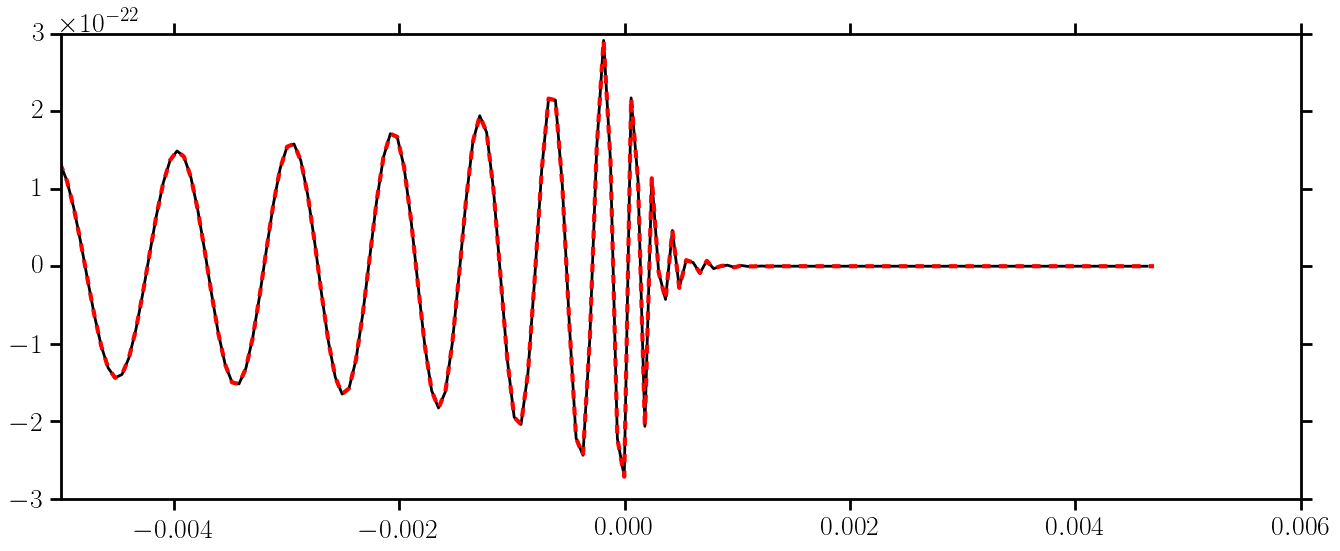

In [115]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(ht4p.sample_times, ht4p, c='k', lw=2)
axes.plot(times, np.real(hresamp), c='r', lw=3, ls='--')
axes.set_xlim(-0.005, 0.006)

In [34]:
# htilde_wave = Waveform.from_complex(freqs, htilde)
# htres = htilde_wave.interpolate_complex()(np.array(ht4p_tilde.sample_frequencies))

In [ ]:
phase = phi0 - 2.0*np.pi*freq*tpm + c*((freq-f1)/(f2-f1))**2

(400, 3000)

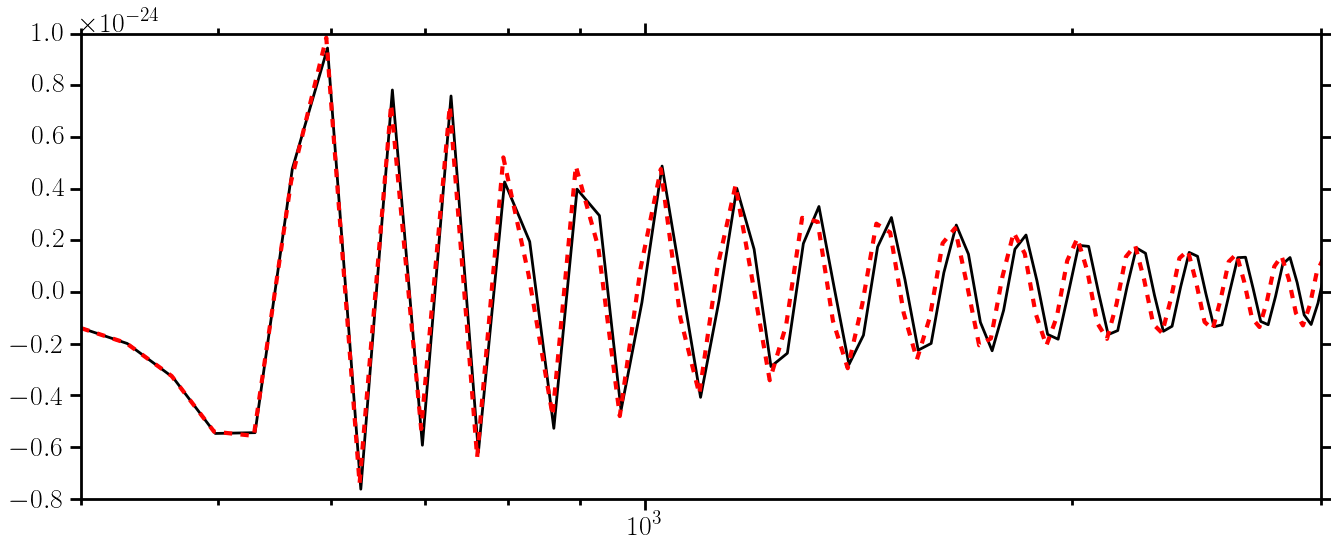

In [116]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(np.array(ht4p_tilde.sample_frequencies), np.real(np.array(ht4p_tilde)+1.0j*np.array(ht4c_tilde)), c='k', lw=2)
axes.plot(freqs, np.real(htilde), c='r', lw=3, ls='--')
#axes.plot(np.array(ht4p_tilde.sample_frequencies), np.real(htres), c='g', lw=3, ls=':')
axes.set_xscale('log')
axes.set_xlim(400, 3000)

# Test impact of changing sampling frequency of FFT

In [163]:
distance, inclination, f_lower = 100.0, 0.0, 300.0
mass1, mass2 = 1.4, 1.4

delta_t = 1.0/2**15
hp1, hc1 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
hp1_tilde = hp1.to_frequencyseries()

delta_t = 1.0/2**16
hp2, hc2 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)
hp2_tilde = hp2.to_frequencyseries()


(100, 5000)

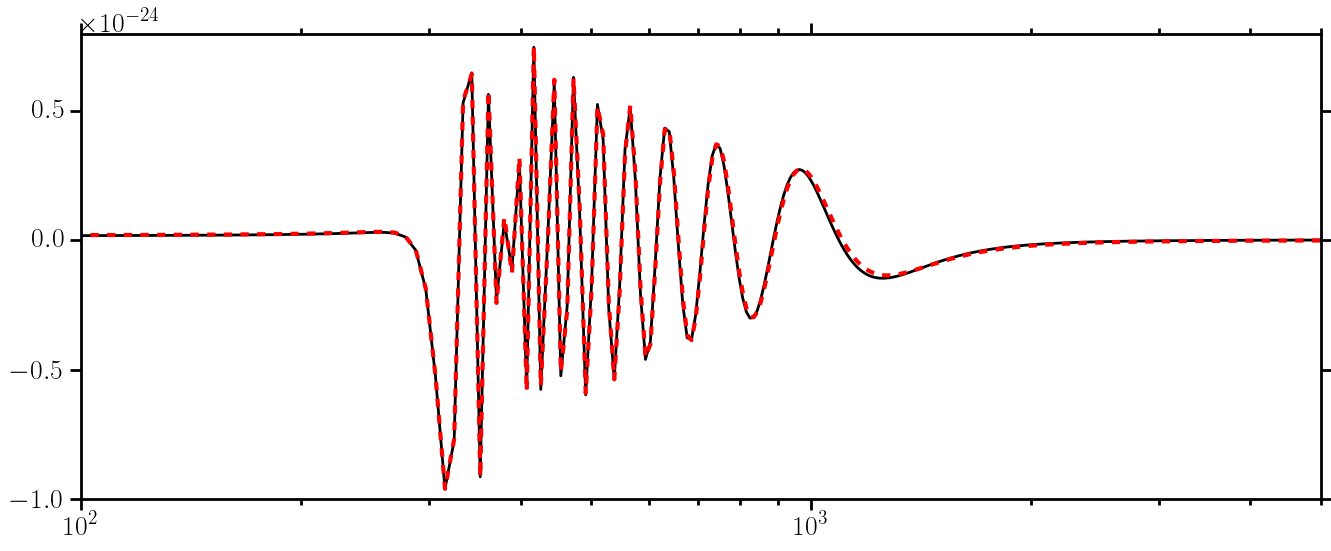

In [164]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(np.array(hp1_tilde.sample_frequencies), np.real(np.array(hp1_tilde)), c='k', lw=2)
axes.plot(np.array(hp2_tilde.sample_frequencies), np.real(np.array(hp2_tilde)), c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_xlim(100, 5000)

In [165]:
h1 = Waveform.from_complex(np.array(hp1_tilde.sample_frequencies), np.array(hp1_tilde))
h2 = Waveform.from_complex(np.array(hp2_tilde.sample_frequencies), np.array(hp2_tilde))

(400, 5000)

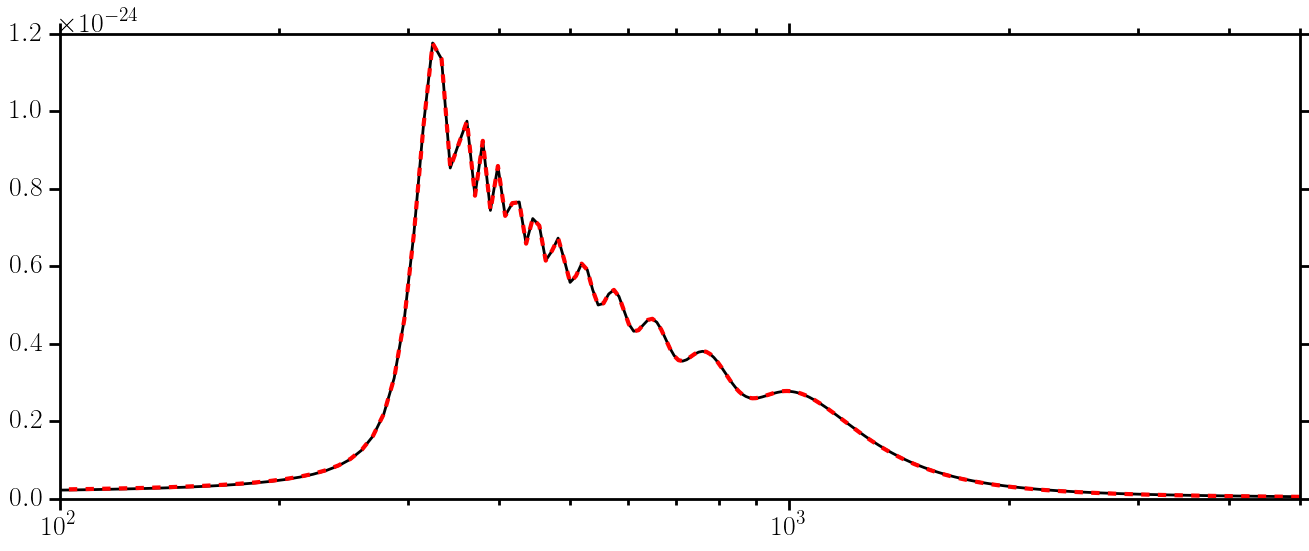

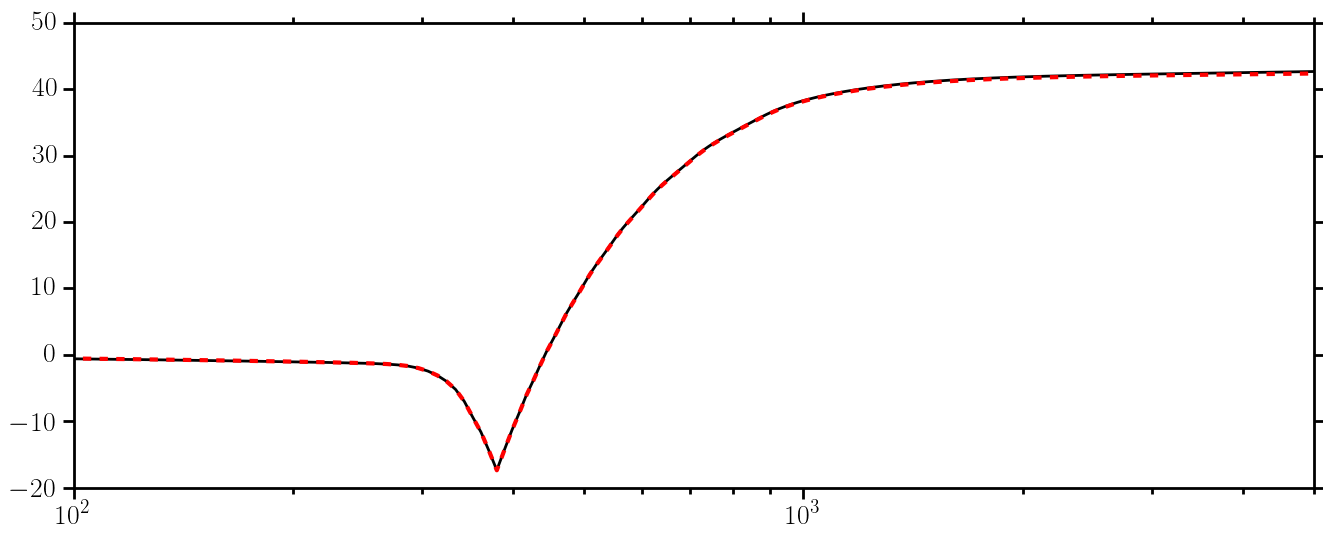

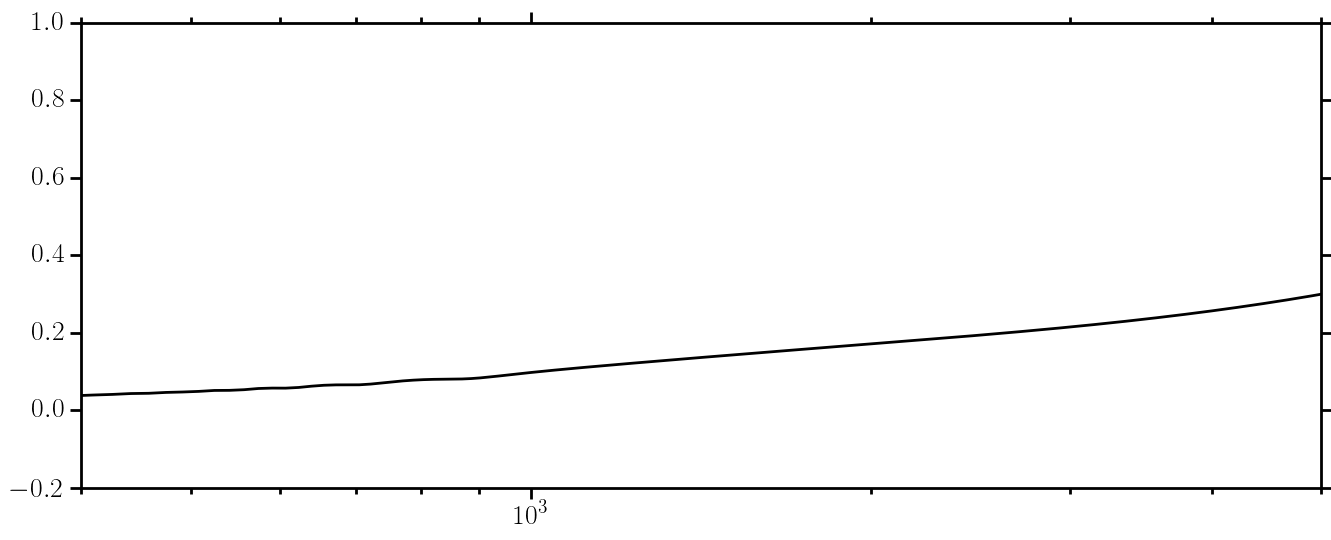

In [166]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1.x, h1.amp, c='k', lw=2)
axes.plot(h2.x, h2.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_xlim(100, 5000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1.x, h1.phase, c='k', lw=2)
axes.plot(h2.x, h2.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_xlim(100, 5000)

diff = subtract_waveform_phase(h1, h2)
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.set_xscale('log')
axes.set_xlim(400, 5000)

# Check impact of windowing waveform on Fourier transform

In [282]:
def plot_waveforms(axes, waveforms, xi=-np.inf, xf=np.inf, npoints=1000):
    axes.axhline(0.0, color='k', ls=':')
    
    for h in waveforms:
        xiplot = max(xi, h.x[0])
        xfplot = min(xf, h.x[-1])
        hcomp = h.interpolate_complex()
        times = np.linspace(xiplot, xfplot, npoints)
        hs = hcomp(times)
        
        axes.plot(times, np.real(hs))
        axes.plot(times, np.abs(hs))

In [283]:
def fourier_transform_waveform(h, dt):
    hresamp = h.interpolate_complex()(h.x)
    npoints = len(hresamp)
    freqs, htilde = fourier_transform(hresamp, dt)
    return Waveform.from_complex(freqs, htilde)

In [416]:
def truncate_beginning(h, xstart, remove_start_phase=False):
    """
    """
    ampint = h.interpolate('amp')
    phaseint = h.interpolate('phase')
    istart = np.searchsorted(h.x, xstart)
    if xstart == h.x[istart]:
        xnew = h.x[istart:]
    else:
        xnew = np.concatenate(([xstart], h.x[istart:]))
    return Waveform.from_amp_phase(xnew, ampint(xnew), phaseint(xnew), remove_start_phase=remove_start_phase)

In [426]:
distance, inclination, f_lower = 100.0, 0.0, 200.0
mass1, mass2 = 1.4, 1.4

delta_t = 1.0/2**18
hp1, hc1 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
                        mass1=mass1, mass2=mass2, 
                        distance=distance, inclination=inclination, 
                        delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)

# delta_t = 1.0/2**16
# hp2, hc2 = pycbc.waveform.get_td_waveform(approximant='TaylorT4', 
#                         mass1=mass1, mass2=mass2, 
#                         distance=distance, inclination=inclination, 
#                         delta_t=delta_t, f_lower=f_lower, f_ref=f_lower)

In [ ]:
h1 = Waveform.from_hp_hc(np.array(hp1.sample_times), np.array(hp1), np.array(hc1))
#h2 = Waveform.from_hp_hc(np.array(hp2.sample_times), np.array(hp2), np.array(hc2))

h2 = window_waveform(h1, h1.x[0]+0.100, h1.x[-1]-0.010)

fig, axes = plt.subplots(1, figsize=(16, 6))
plot_waveforms(axes, [h1, h2])
axes.minorticks_on()

In [424]:
h1tilde = fourier_transform_waveform(h1, delta_t)
h2tilde = fourier_transform_waveform(h2, delta_t)

h1trunc = truncate_beginning(h1tilde, 100, remove_start_phase=True)
h2trunc = truncate_beginning(h2tilde, 100, remove_start_phase=True)

(100, 5000)

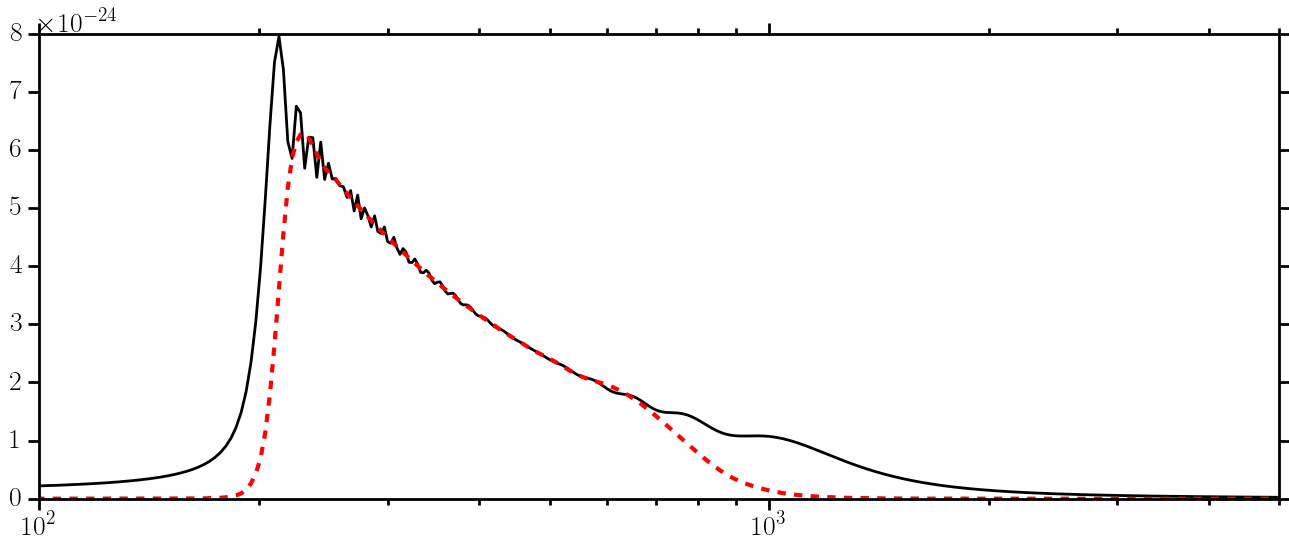

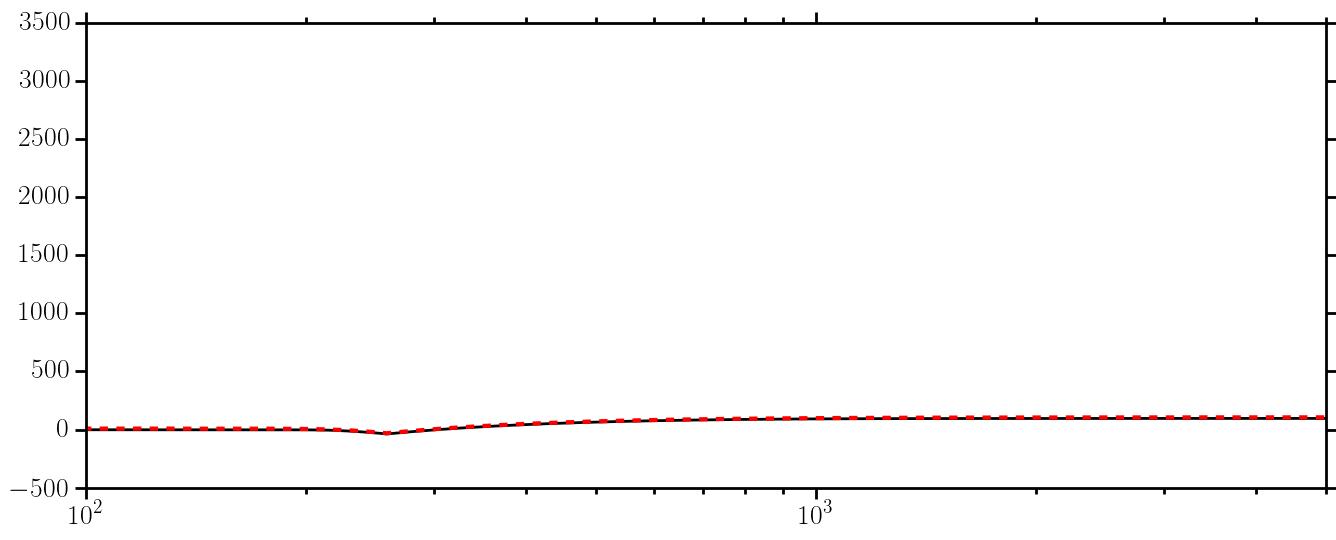

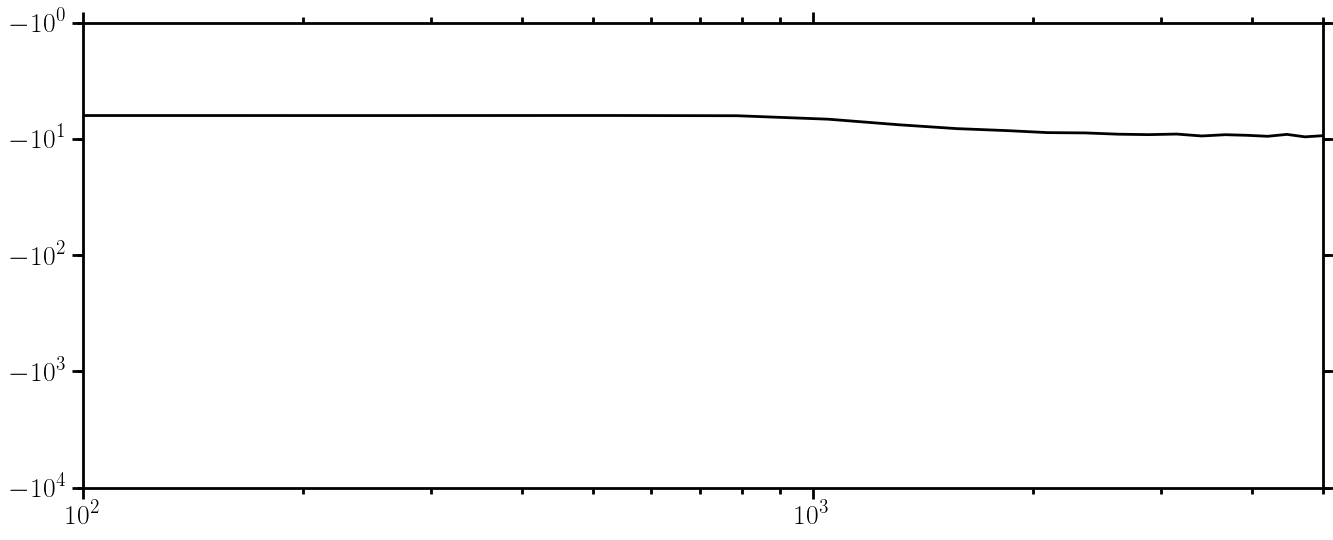

In [425]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1tilde.x, h1tilde.amp, c='k', lw=2)
axes.plot(h2tilde.x, h2tilde.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlim(100, 5000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1tilde.x, h1tilde.phase, c='k', lw=2)
axes.plot(h2tilde.x, h2tilde.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_xlim(100, 5000)

diff = subtract_waveform_phase(h1tilde, h2tilde)
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.set_xscale('log')
axes.set_yscale('symlog', linthreshy=1.0)
axes.set_xlim(100, 5000)

(100, 5000)

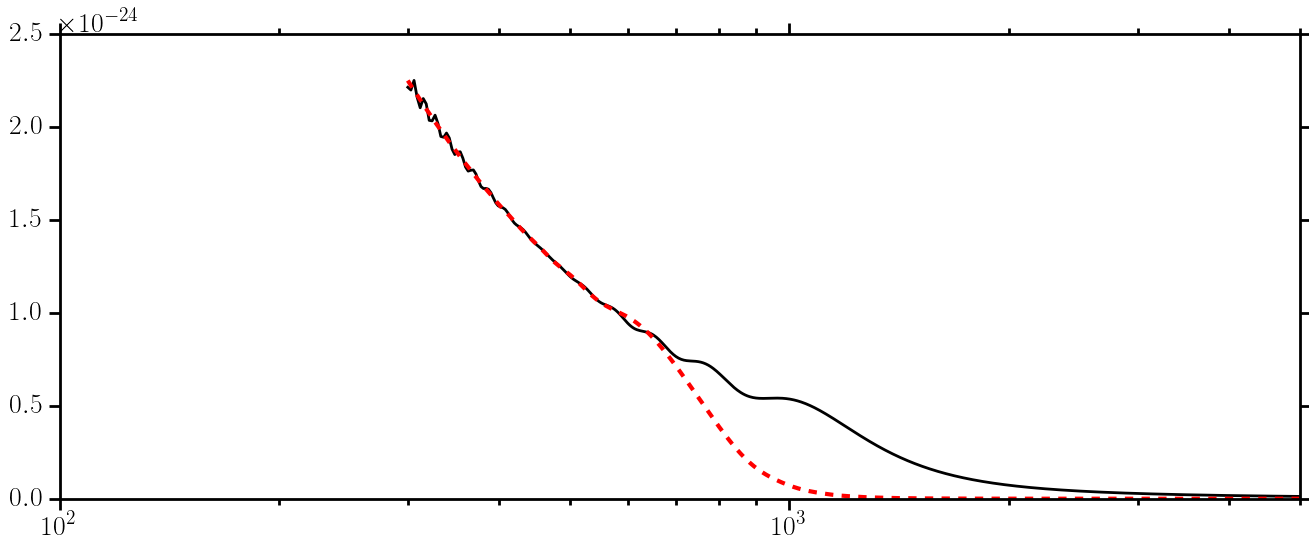

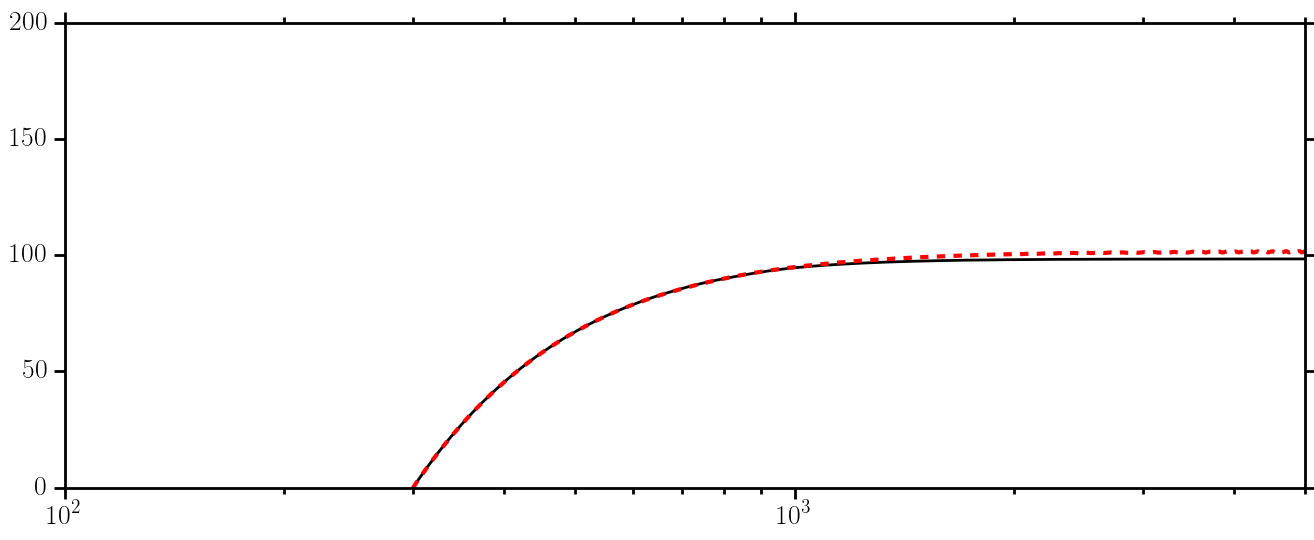

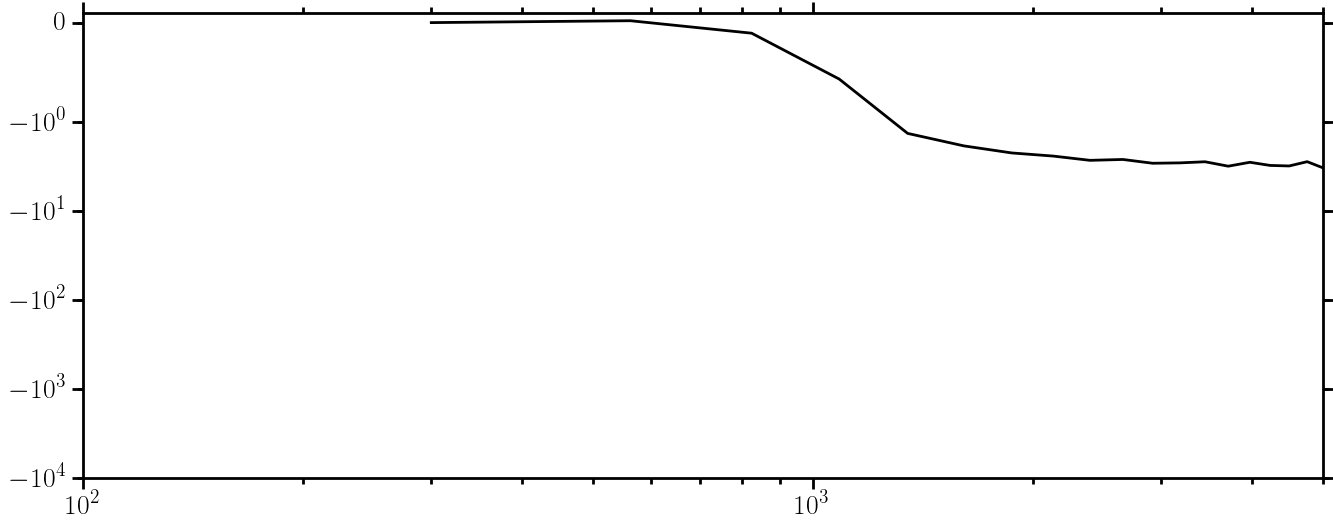

In [344]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1trunc.x, h1trunc.amp, c='k', lw=2)
axes.plot(h2trunc.x, h2trunc.amp, c='r', lw=3, ls='--')
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlim(100, 5000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(h1trunc.x, h1trunc.phase, c='k', lw=2)
axes.plot(h2trunc.x, h2trunc.phase, c='r', lw=3, ls='--')
axes.set_xscale('log')
axes.set_xlim(100, 5000)
axes.set_ylim(0, 200)

diff = subtract_waveform_phase(h1trunc, h2trunc)
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.set_xscale('log')
axes.set_yscale('symlog', linthreshy=1.0)
axes.set_xlim(100, 5000)

# TaylorF2 waveform

In [386]:
################################################
# !!!You should also add in the tidal terms!!!
################################################
def taylort4_xdot(freq, mass1, mass2):
    """3.5PN point-particle amplitude.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    euler_gamma = 0.5772156649015329
    mtot = mass1 + mass2
    eta = mass1 * mass2 / mtot**2
    
    # Calculate the coefficients once
    xdot00 = (64.0*eta)/5.0
    
    xdot10 = -( (743.0 + 924.0*eta)/336.0 )

    xdot15 = 4.0*np.pi

    xdot20 = 34103.0/18144.0 + (13661.0*eta)/2016.0 + (59.0*eta**2)/18.0

    xdot25 = -( 4159.0/672.0 + 15876.0*eta/672.0 )*np.pi

    xdot30 = 16447322263.0/139708800.0 - (1712.0*euler_gamma)/105.0 \
    + (16.0*np.pi**2)/3.0 - (856.0*np.log(16.0))/105.0 \
    - ( 56198689.0/217728.0 - (451.0*np.pi**2/48.0) )*eta \
    + (541.0*eta**2)/896.0 \
    - (5605*eta**3)/2592.0

    xdot30ln = -(856.0/105.0)

    xdot35 = -( 4415.0/4032.0 - (358675.0*eta)/6048.0 - (91495*eta**2)/1512.0 )*np.pi
    
    #print xdot00, xdot10, xdot15, xdot20, xdot25, xdot30, xdot30ln, xdot35
    
    # Now calculate phase for each freq
    # !!! Find a way of dealing with the divide by zero at f=0 !!!
    x = (np.pi * G_SI * MSUN_SI * mtot * freq / C_SI**3)**(2.0/3.0)

    xdot = xdot00*x**5 * (1.0 + xdot10*x + xdot15*x**1.5 + xdot20*x**2 + xdot25*x**2.5 \
                          + (xdot30+xdot30ln*np.log(x))*x**3 + xdot35*x**3.5)
    return xdot

In [387]:
################################################
# !!!You should also add in the tidal terms!!!
################################################
def taylorf2_amp(freq, dist, mass1, mass2):
    """3.5PN point-particle amplitude.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    euler_gamma = 0.5772156649015329
    mtot = mass1 + mass2
    eta = mass1 * mass2 / mtot**2
    
    # Calculate the coefficients once
    
    a00 = -8.0*np.sqrt(np.pi/5.0)*eta
    
    a10 = -(107.0/42.0) + (55.0*eta)/42.0
    
    a15 = 2.0*np.pi
    
    a20 = -(2173.0/1512.0) - (1069.0*eta)/216.0 + (2047.0*eta**2/1512.0)
    
    a25 = -(107.0*np.pi)/21.0 + ( (34.0*np.pi)/21.0 - 24.0j )*eta
    
    a30 = 27027409.0/646800.0 - (856.0*euler_gamma)/105.0 + (2*np.pi**2)/3.0 \
    - (428.0*np.log(16.0))/105.0 + (428.0j*np.pi)/105.0 \
    + ( -278185.0/33264.0 + (41.0*np.pi**2)/96.0 )*eta \
    - (20261.0*eta**2)/2772.0 \
    + (114635.0*eta**3)/99792.0
    
    a30ln = -428.0/105.0
    
    #print a00, a10, a15, a20, a25, a30, a30ln
    
    # Now calculate phase for each freq
    # !!! Find a way of dealing with the divide by zero at f=0 !!!
    x = (np.pi * G_SI * MSUN_SI * mtot * freq / C_SI**3)**(2.0/3.0)
    
    A22 = a00*x*( 1.0 + a10*x + a15*x**1.5 + a20*x**2 + a25*x**2.5 + (a30+a30ln*np.log(x))*x**3 )
    
    # Use TaylorT4 value for xdot
    xdot = taylort4_xdot(freq, mass1, mass2)
    
    # A22 has a very small phase component. Ignore it by taking the absolute value.
    A22tilde = np.abs(A22) * np.sqrt( 2.0 * np.pi / (3.0 * x**0.5 * xdot) )
   
    return 0.5*np.sqrt(5.0/np.pi) * (G_SI*MSUN_SI*mtot)**2/(C_SI**5*MPC_SI*dist) * A22tilde

In [388]:
################################################
# !!!You should also add in the tidal terms!!!
################################################
def taylorf2_phase(freq, tc, phic, mass1, mass2):
    """3.5PN point-particle phase.
    FFT sign convention is $\tilde h(f) = \int h(t) e^{-2 \pi i f t} dt$
    where $h(t) = h_+(t) + i h_\times(t)$.
    """
    euler_gamma = 0.5772156649015329
    mtot = mass1 + mass2
    eta = mass1 * mass2 / mtot**2
    
    # Calculate the coefficients once
    a00 = 3.0/(128.0*eta)
    
    a10 = 3715.0/756.0 + 55.0*eta/9.0
    
    a15 = -16.0*np.pi
    
    a20 = 15293365.0/508032.0 + (27145.0*eta)/504.0 + (3085.0*eta**2)/72.0
    
    a25 = (38645.0/756.0 - 65.0*eta/9)*np.pi
    
    a25ln = (3.0/2.0) * (38645.0/756.0 - (65.0*eta)/9.0)*np.pi
    
    a30 = 11583231236531.0/4694215680.0 - (6848.0*euler_gamma)/21.0 - (640.0*np.pi**2)/3.0 - 6848.0/63.0*np.log(64.0) \
    + (-15737765635.0/3048192.0 + (2255.0*np.pi**2)/12.0)*eta \
    + (76055.0*eta**2)/1728.0 \
    - (127825.0*eta**3)/1296.0
    
    a30ln = -(3.0/2.0) * 6848.0/63.0
    
    a35 = (77096675.0/254016.0 + (378515.0*eta)/1512.0 - (74045.0*eta**2)/756.0)*np.pi
    
    #print a00, a10, a15, a20, a25, a25ln, a30, a30ln, a35
    
    # Now calculate phase for each freq
    # !!! Find a way of dealing with the divide by zero at f=0 !!!
    x = (np.pi * G_SI * MSUN_SI * mtot * freq / C_SI**3)**(2.0/3.0)

    phi = -2.0*np.pi*freq*tc + phic + np.pi/4.0 \
    - a00*x**(-5.0/2.0)*(1.0 + a10*x + a15*x**1.5 + a20*x**2.0 \
                         + (a25+a25ln*np.log(x))*x**2.5 \
                         + (a30+a30ln*np.log(x))*x**3.0 \
                         + a35*x**3.5)
    return phi

In [398]:
def taylorf2(f_lower=None, f_upper=None, delta_f=None, 
             distance=None, mass1=None, mass2=None, tc=0.0, phic=0.0):
    """
    """
    freq = np.arange(f_lower, f_upper, delta_f)
    amp = taylorf2_amp(freq, distance, mass1, mass2)
    phase = taylorf2_phase(freq, tc, phic, mass1, mass2)
    return Waveform.from_amp_phase(freq, amp, phase)

In [417]:
mass1, mass2 = 1.4, 1.4
dist = 100.0
hf2 = taylorf2(f_lower=100.0, f_upper=5000.0, delta_f=1.0, distance=dist, mass1=mass1, mass2=mass2)
hf2trunc = truncate_beginning(hf2, 300, remove_start_phase=True)

(0, 200)

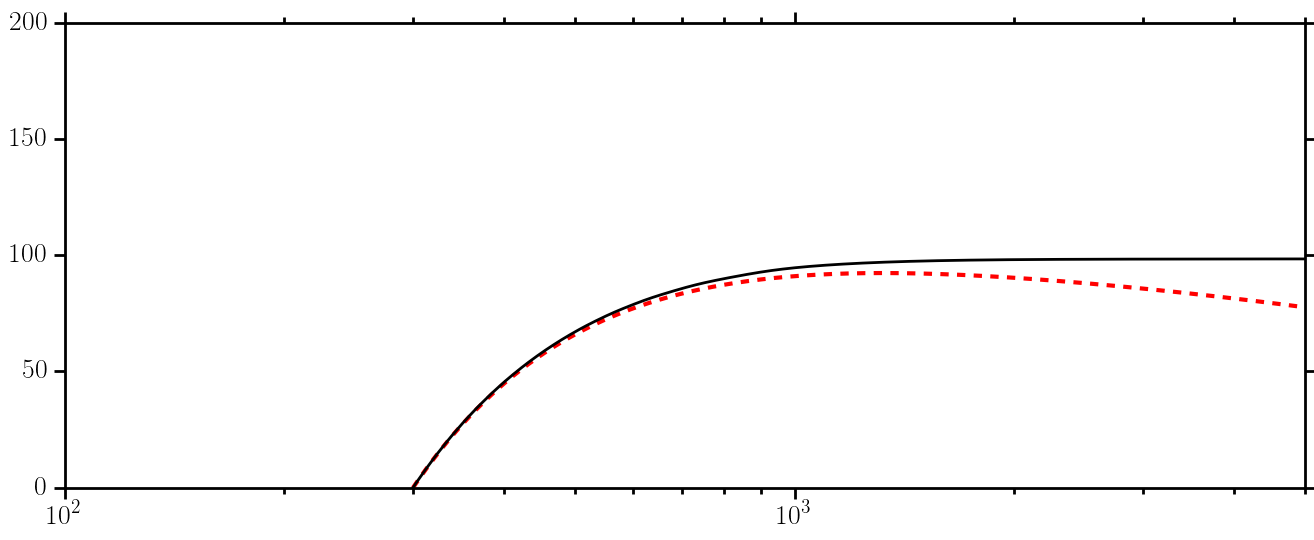

In [402]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(hf2trunc.x, hf2trunc.phase, c='r', lw=3, ls='--')
axes.plot(h1trunc.x, h1trunc.phase, c='k', lw=2)
axes.set_xscale('log')
axes.set_xlim(100, 5000)
axes.set_ylim(0, 200)

(100, 5000)

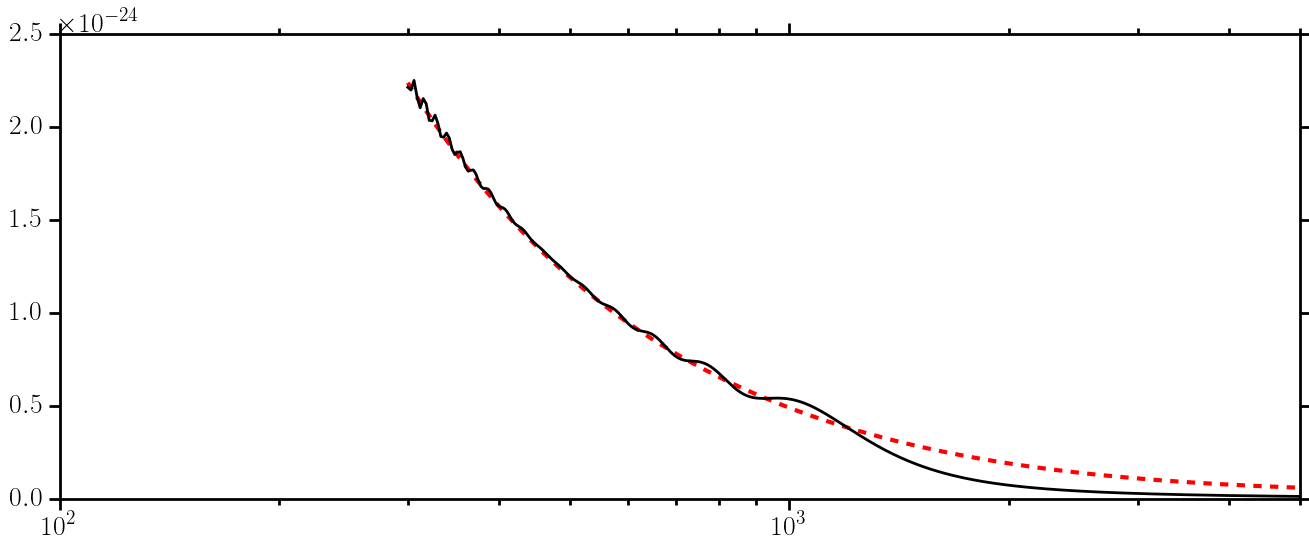

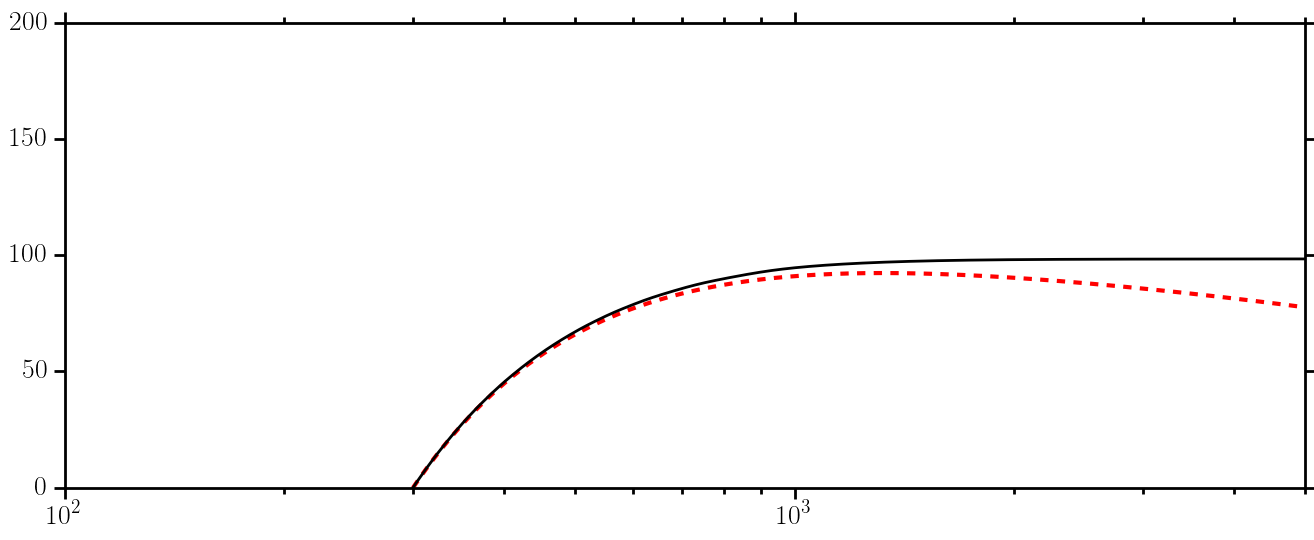

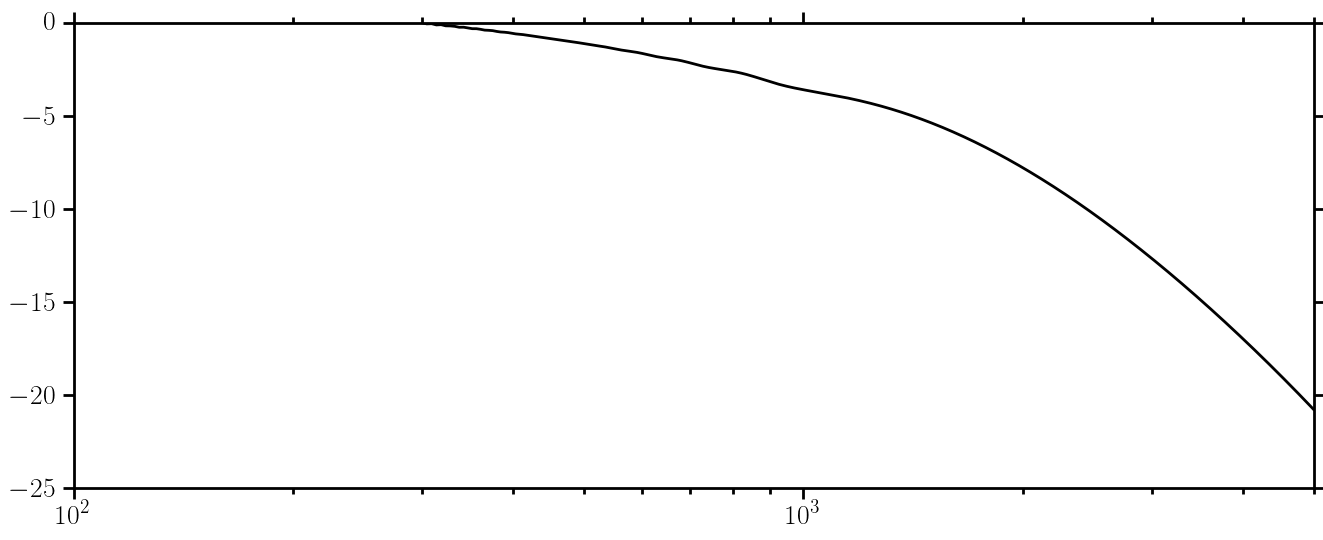

In [421]:
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(hf2trunc.x, hf2trunc.amp, c='r', lw=3, ls='--')
axes.plot(h1trunc.x, h1trunc.amp, c='k', lw=2)
axes.set_xscale('log')
#axes.set_yscale('log')
axes.set_xlim(100, 5000)

fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(hf2trunc.x, hf2trunc.phase, c='r', lw=3, ls='--')
axes.plot(h1trunc.x, h1trunc.phase, c='k', lw=2)
axes.set_xscale('log')
axes.set_xlim(100, 5000)
axes.set_ylim(0, 200)

diff = subtract_waveform_phase(hf2trunc, h1trunc)
fig, axes = plt.subplots(1, figsize=(16, 6))
axes.plot(diff.x, diff.phase, c='k', lw=2)
axes.set_xscale('log')
#axes.set_yscale('symlog', linthreshy=1.0)
axes.set_xlim(100, 5000)